# Ames Housing Prices

In this project i will be conducting a full EDA of the Ames housing dataset from Kaggle.

I have already spent some time getting to know the data set and i have fit a few different models and performed some tuning on them. My model accuracy up to now has been poor and that is due to the lack of cleaning and preproccessing.

My objective in this project is to optimize the data before tuning models to obtain the best accuracy possible. 

I will begin by performing some initial exploration of the target variable, features and interactions. I will then figure out how best to deal with NaN values and change some of the data types of my columns. 

Finally i will have a look at some feature engineering and see if i can drop or combine some of the more redundant columns.



In [1]:
# Import initial packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings 

from scipy import stats

from scipy.stats import norm

#warnings.filterwarnings('ignore')

In [2]:
import xgboost as xgb

from sklearn.linear_model import LinearRegression,Lasso,ElasticNet,LassoCV

from sklearn.model_selection import RandomizedSearchCV,train_test_split

from sklearn.metrics import mean_squared_error

In [3]:
# read in train and test datasets
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')






In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

## Sale Price

Sale price is our target variable so it will be useful to take a look at this first. From looking at the histogram below, we can see that the data has a positive skew and peakedness.

I can take a log of the Sale price column to create a more normal distribution as shown in the second histogram. 



1.8828757597682129
6.536281860064529


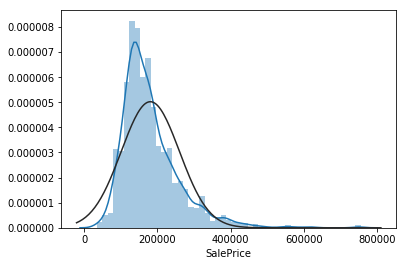

In [5]:
sns.distplot(df['SalePrice'],fit=norm)

print(df['SalePrice'].skew())
print(df['SalePrice'].kurt())

0.12134661989685333
0.809519155707878


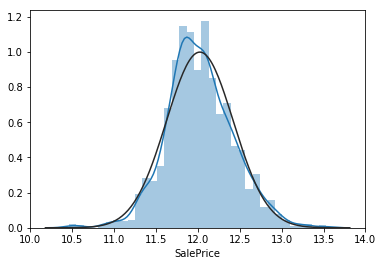

In [6]:
logged = np.log1p(df['SalePrice'])

sns.distplot(logged,fit=norm)

print(logged.skew())
print(logged.kurt())

# Finding the key variables. 

I will be taking a look at a heatmap of the data. This will help me find the most important links between Sale Price and my numeric values. It will also help me to find any multicolinearities between the data. From looking at the heatmap i can already see that Garage cars and garage area are very strongly linked. As the area directly affects the amount of cars this makes sense and i will likely drop the garage area later.

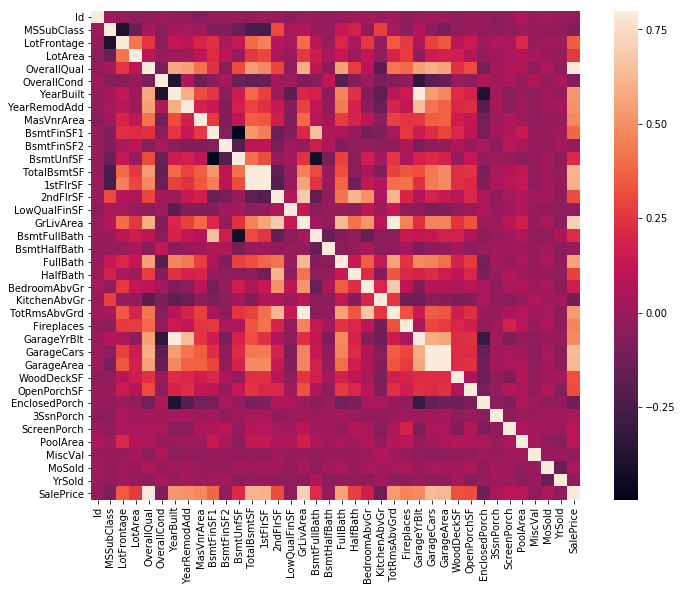

In [7]:
df_corrmat= df.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(df_corrmat,vmax=0.8,square=True)

# Important variables

Next up i will take a look at some of the most important variables in our dataset. Firstly, we will look at the above ground living area. This has a strong linear relationship with sales price which makes a lot of sense. Bigger house, bigger price. After taking a look at the data i decided to drop the two big outliers with a living area over 4500. 


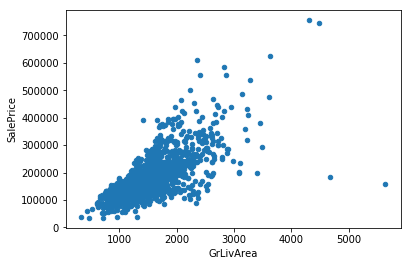

In [8]:
df.plot('GrLivArea','SalePrice',kind='scatter')

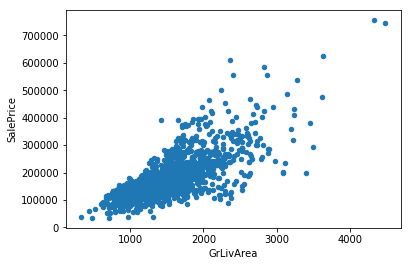

In [9]:
# Dropping the two biggest outliers from the data

outliers = df[df['GrLivArea']>4500]

df.drop(outliers.index,inplace=True,axis=0)

df.plot('GrLivArea','SalePrice',kind='scatter')



# Creating a combined Dataframe



In [10]:
# Making a reference for the number of rows so we can split the train and test data later. 
n_rows = len(df)

#Converting Sale price to a log format 
df['SalePrice'] = np.log1p(df['SalePrice'])
# setting up the target variable so we can drop sale price
y = df['SalePrice']

#concat train and test data
everything = pd.concat([df,df_test],axis=0,sort=False,ignore_index=True)

everything.drop(['SalePrice','Id'],inplace=True,axis=1)

# NaN's 

Next up i need to sort out the NaN values in my dataset. From previous data exploration i've realised that not all of these values are necessarily real NaN values. Some columns such as pool area are NaN because the house doesn't have a pool. 

First up i will be taking a look at the NaN columns and categorising them in to different methods of filling.

In [11]:
# i created a simple function to help me find NaN values 

def find_nulls ():
    is_null=everything.isnull().sum().sort_values(ascending=False)

    null_cols=is_null[is_null>0]

    print(null_cols)



In [12]:
# For pool area we can see that most of the dataset is 0 as most houses don't have pools. We also have lots of NaN values for 
# pool quality. I will drop pool quality and create a binary column with pool or no pool. 


everything.drop('PoolQC',inplace=True,axis=1)
everything['PoolArea'] = everything['PoolArea'].apply(lambda x: 1 if x>0 else 0)

everything['HasPool'] = everything['PoolArea'].astype('str')

everything.drop('PoolArea',inplace=True,axis=1)

# None Columns

Next i will search through the data for all of the columns which i can fill with 'None'. This will be columns such as MiscFeature where having a NaN value just means that there are no miscellaneous features. 

In [13]:
none_cols =['MiscFeature','Alley','Fence','FireplaceQu','GarageCond','GarageQual','GarageFinish','GarageType','BsmtCond',
            'BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1']

for col in none_cols:
    everything[col].fillna('none',inplace=True)

## Lot Frontage

for these NaN values I've decided to fill them based on the linear relation with Lot Area. Intuitively these values would be linked and the data does show a fairly strong linear relationship. I think that this will be more effective than just filling with the mean.

I created a linear regression model and fitted it to lot area to give me predictions on my NaN values. I then filled the lot frontage with these predictions.

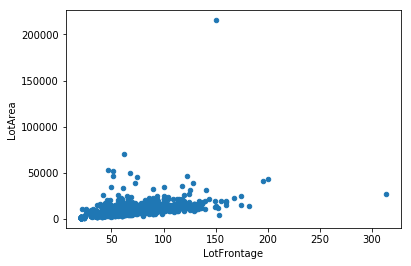

In [14]:

everything.plot('LotFrontage','LotArea',kind='scatter')

In [15]:
#Instansiate a new linear regression
simple_reg = LinearRegression()

#create a dataframe of Lot area and Lot frontage
small_df = everything[['LotArea','LotFrontage']]

# make a mask for the NaN values
mask=small_df['LotFrontage'].isnull()

#filter the data frame to get all NaN values of lot front and then select the lot area to be our test X value
small_X_test = small_df[mask]['LotArea'].values.reshape(-1,1)

# drop all NaN values 
small_df_clean = small_df.dropna()

# set up training values for X
small_X_train = small_df_clean['LotArea'].values.reshape(-1,1)

# set up training values for y
small_y = small_df_clean['LotFrontage'].values.reshape(-1,1)

# fit the model
simple_reg.fit(small_X_train,small_y)

# create predictions
small_y_preds=simple_reg.predict(small_X_test)

# create a DF with all NaN values
unclean_small_df = small_df[mask]

#Insert predictions in to DF
unclean_small_df['LotFrontage']=small_y_preds

#create a series so i can fill Lot front with it. 
filler=unclean_small_df['LotFrontage']


C:\Users\jim\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
everything['LotFrontage'].fillna(filler,inplace=True)

# Garage

for the garage year built NaN's i will be filling this with the year built value. Most of these houses will probably not have a garage, so i will use the year built to not create major outliers in the data.

In [17]:
garage_filler = everything[everything['GarageYrBlt'].isnull()]['YearBuilt']

everything['GarageYrBlt'].fillna(garage_filler,inplace=True)

# The final NaN's

There are not many NaN values left in my table so i will just fill the rest with the column mode. 

In [18]:
is_na = everything.columns[everything.isna().any()].to_list()

for col in is_na:
    everything[col].fillna(everything[col].mode()[0],inplace=True)

## Feature engineering and dropping columns

I will be dropping some columns that are reduntant for the data.I will also be creating some new columns that i think will be helpful. 

For example i would like to create one variable for the number of baths in the house,regardless of the floor. I would also like to create a variable for total square footage of the house

In [19]:


everything['NumberBaths'] = everything['FullBath'] + everything['BsmtFullBath'] + 0.5*everything['HalfBath']+0.5*everything['BsmtHalfBath']

everything['TotalSF'] = everything['GrLivArea']+everything['TotalBsmtSF']

# dropping columns that are redundant
everything.drop(['GarageArea','FireplaceQu','LandSlope','BldgType','HouseStyle','RoofMatl','Exterior2nd','GarageType',
                'GarageFinish'],inplace=True,axis=1)


# Inspect the numeric columns

Next up i want to have a look at the numeric columns in my data. I want to check if there are any that i can transform to improve my model accuracy. 

In [23]:
numeric_df = everything.select_dtypes(exclude='object')

numeric_cols = list(numeric_df.columns)

In [24]:
skewed_columns = everything[numeric_cols].skew()

print(skewed_columns)

MSSubClass        1.375838
LotFrontage       2.128114
LotArea          13.116240
OverallQual       0.189688
OverallCond       0.569607
YearBuilt        -0.599503
YearRemodAdd     -0.450365
MasVnrArea        2.623068
BsmtFinSF1        0.981149
BsmtFinSF2        4.146636
BsmtUnfSF         0.920161
TotalBsmtSF       0.672097
1stFlrSF          1.257933
2ndFlrSF          0.861999
LowQualFinSF     12.090757
GrLivArea         1.069300
BsmtFullBath      0.622735
BsmtHalfBath      3.932018
FullBath          0.165599
HalfBath          0.697024
BedroomAbvGr      0.326736
KitchenAbvGr      4.302763
TotRmsAbvGrd      0.749618
Fireplaces        0.725651
GarageYrBlt      -0.459795
GarageCars       -0.218422
WoodDeckSF        1.845741
OpenPorchSF       2.530660
EnclosedPorch     4.004404
3SsnPorch        11.377932
ScreenPorch       3.947131
MiscVal          21.950962
MoSold            0.197447
YrSold            0.132064
NumberBaths       0.486693
TotalSF           1.012326
dtype: float64


In [25]:


skewed_columns = skewed_columns[skewed_columns>1]

everything[skewed_columns.index] = np.log1p(everything[skewed_columns.index])



In [26]:
everything[numeric_cols].skew()

MSSubClass       0.246056
LotFrontage     -0.899930
LotArea         -0.532920
OverallQual      0.189688
OverallCond      0.569607
YearBuilt       -0.599503
YearRemodAdd    -0.450365
MasVnrArea       0.538731
BsmtFinSF1       0.981149
BsmtFinSF2       2.462526
BsmtUnfSF        0.920161
TotalBsmtSF      0.672097
1stFlrSF         0.030374
2ndFlrSF         0.861999
LowQualFinSF     8.559041
GrLivArea       -0.022062
BsmtFullBath     0.622735
BsmtHalfBath     3.775149
FullBath         0.165599
HalfBath         0.697024
BedroomAbvGr     0.326736
KitchenAbvGr     3.520694
TotRmsAbvGrd     0.749618
Fireplaces       0.725651
GarageYrBlt     -0.459795
GarageCars      -0.218422
WoodDeckSF       0.159605
OpenPorchSF     -0.041559
EnclosedPorch    1.960960
3SsnPorch        8.826656
ScreenPorch      2.946085
MiscVal          5.214687
MoSold           0.197447
YrSold           0.132064
NumberBaths      0.486693
TotalSF         -0.420412
dtype: float64

In [27]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler

In [28]:


scaler=MinMaxScaler()

everything[numeric_cols] = pd.DataFrame(scaler.fit_transform(everything[numeric_cols]),columns=numeric_df.columns)

C:\Users\jim\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [29]:
everything = pd.get_dummies(everything)

In [30]:
X = everything[:n_rows]

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1,test_size=0.25)

test_data = everything[n_rows:]



In [31]:
xgb_mod = xgb.XGBRegressor(n_estimators= 360, max_depth= 2, learning_rate= 0.1)

lr_mod=LinearRegression()

las_mod  = LassoCV(alphas = [1, 0.1, 0.001, 0.0005])

elas_mod = ElasticNet()

models = {'xgb':xgb_mod,'lasso':las_mod,'elastic':elas_mod}



for name,model in models.items():
    model.fit(X_train,y_train)
    print('{} has an R^2 score of:'.format(name))
    print(model.score(X_test,y_test))
    pred = model.predict(X_test)
    print('and an MSE of:')
    print(mean_squared_error(y_test,pred))
    print('\n ')
    
    
    

C:\Users\jim\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:42:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgb has an R^2 score of:
0.9055397275444079
and an MSE of:
0.014905559903223127

 


C:\Users\jim\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


lasso has an R^2 score of:
0.9137687197626516
and an MSE of:
0.013607048547458698

 
elastic has an R^2 score of:
-0.0006646457694585717
and an MSE of:
0.1579020093083715

 


In [32]:
model_2=xgb.XGBRegressor(n_estimators= 360, max_depth= 2, learning_rate= 0.1 )
model_3 = las_mod
model_2.fit(X,y)
model_3.fit(X,y)
preds_xgb= np.expm1(model_2.predict(test_data))
preds_las = np.expm1(model_3.predict(test_data))
subs= pd.DataFrame()

subs['ID'] = df_test['Id']
subs['SalePrice'] = 0.7*preds_las+0.3*preds_xgb
subs.to_csv('ames_predictions.csv',index=False)

[22:42:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\jim\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\jim\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
C:\Users\jim\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
